In [ ]:
import yaml
import epo_ops
import pandas as pd
import xml.etree.ElementTree as ET
import re
import numpy as np
import json
import time
import requests
from bs4 import BeautifulSoup
from langdetect import detect, DetectorFactory
import html
import random
import langdetect
from deep_translator import GoogleTranslator
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
import datetime
! pip install iso3166

In [2]:
patents_text = pd.read_csv("patents_text_deduplicated.csv")

/var/folders/jy/j77v476x03737ryp7gll_0p00000gn/T/ipykernel_25097/1989358710.py:1: DtypeWarning: Columns (18,20,21,23,49,50) have mixed types. Specify dtype option on import or set low_memory=False.
  patents_text = pd.read_csv("patents_text_deduplicated.csv")


In [5]:
patents_text.columns

Index(['country', 'number', 'kind', 'publication_date_EPO', 'title_de_EPO',
       'title_en_EPO', 'title_fr_EPO', 'abstract_de_EPO', 'abstract_en_EPO',
       'abstract_fr_EPO', 'applicant_names', 'applicant_countries',
       'inventor_EPO', 'inventor_countries', 'ipc_codes_EPO', 'cpc_codes_EPO',
       'family_id', 'application_number', 'claims_de', 'claims_en',
       'claims_fr', 'description_de', 'description_en', 'description_fr',
       'publication_number_EPO', 'publication_date_google', 'filing_date',
       'inventor_google', 'abstract_en_google', 'title_en_google',
       'abstract_fr_google', 'title_fr_google', 'abstract_de_google',
       'title_de_google', 'assignee_name', 'assignee_country',
       'cpc_codes_google', 'ipc_codes_google', 'publication_number_GPO',
       'title_GPO', 'assignee_name_GPO', 'inventor_name_GPO',
       'priority_date_GPO', 'filing_date_GPO', 'publication_date_GPO',
       'grant_date_GPO', 'lang_title_en_EPO', 'lang_title_en_google',
       

In [3]:
# define new column assignee_full where assignee_name is taken when available and assignee_name_GPO otherwise
patents_text["assignee_full"] = patents_text["assignee_name"].fillna(patents_text["assignee_name_GPO"])

In [4]:
patents_text["assignee_full"].isnull().sum()

180

## Exploratory data analysis

In [5]:
def find_assignee(string):
    # Convert the search string to lowercase
    string = string.lower()
    # Fill NaN values in 'assignee_full' with an empty string, convert to lowercase, then check for the substring
    mask = patents_text["assignee_full"].fillna('').str.lower().str.contains(string, na=False)
    return patents_text.loc[mask, "assignee_full"].unique()

# Define the mapping of search strings to clean assignee names
assignee_mappings = {
    "Siemens": "Siemens AG",
    "Gen Electr": "General Electric Company",
    "General E": "General Electric Company",
    "Toyota": "Toyota Motor Corporation",
    "Boeing": "The Boeing Company",
    "Bosch": "Robert Bosch GmbH",
    "ZF": "ZF Friedrichshafen AG",
    "Zahnradfabrik F": "ZF Friedrichshafen AG",
    "Samsung": "Samsung Electronics Co., Ltd.",
    "LG": "LG Corporation",
    "Nissan": "Nissan Motor Co., Ltd.",
    "Honda": "Honda Motor Co., Ltd.",
    "Hitachi": "Hitachi, Ltd.",
    "United Tech": "United Technologies Corporation",
    "Huawei": "Huawei Technologies Co., Ltd.",
    "Philips": "Philips N.V.",
    "Mitsubishi": "Mitsubishi Electric Corporation",
    "Qualcomm": "Qualcomm Incorporated",
    "Volkswagen": "Volkswagen AG",
    "VW ": "Volkswagen AG",
    "Panasonic": "Panasonic Corporation",
    "Intel": "Intel Corporation",
    "Hamilton": "Hamilton Company",
    "Rolls Royce": "Rolls-Royce Holdings plc",
    "General Motors": "General Motors Company",
    "NXP": "NXP Semiconductors",
    "Honeywell": "Honeywell International Inc.",
    "Sony": "Sony Corporation",
    "SMA": "SMA Solar Technology AG",
    "Vestas": "Vestas Wind Systems A/S",
    "Delphi": "Delphi Technologies",
    "Peugeot": "Peugeot S.A.",
    "Donaldson": "Donaldson Company, Inc.",
    "ABB": "ABB Ltd.",
    "ST Micro": "STMicroelectronics",
    "Scania": "Scania AB",
    "Toshiba": "Toshiba Corporation",
    "Audi": "Audi AG",
    "BYD": "BYD Company Ltd.",
    "Signify": "Signify N.V.",
    "Eaton": "Eaton Corporation",
    "Fujitsu": "Fujitsu Limited",
    "IBM": "International Business Machines Corporation"
}

# Initialize the 'assignee_clean' column
patents_text["assignee_clean"] = patents_text["assignee_full"]

# Apply the mappings
for key, value in assignee_mappings.items():
    unique_assignees = find_assignee(key)
    patents_text["assignee_clean"] = patents_text["assignee_clean"].apply(
        lambda x: value if x in unique_assignees else x
    )



In [7]:
print(patents_text.assignee_clean.nunique())
print(patents_text.assignee_full.nunique())

6647
7119


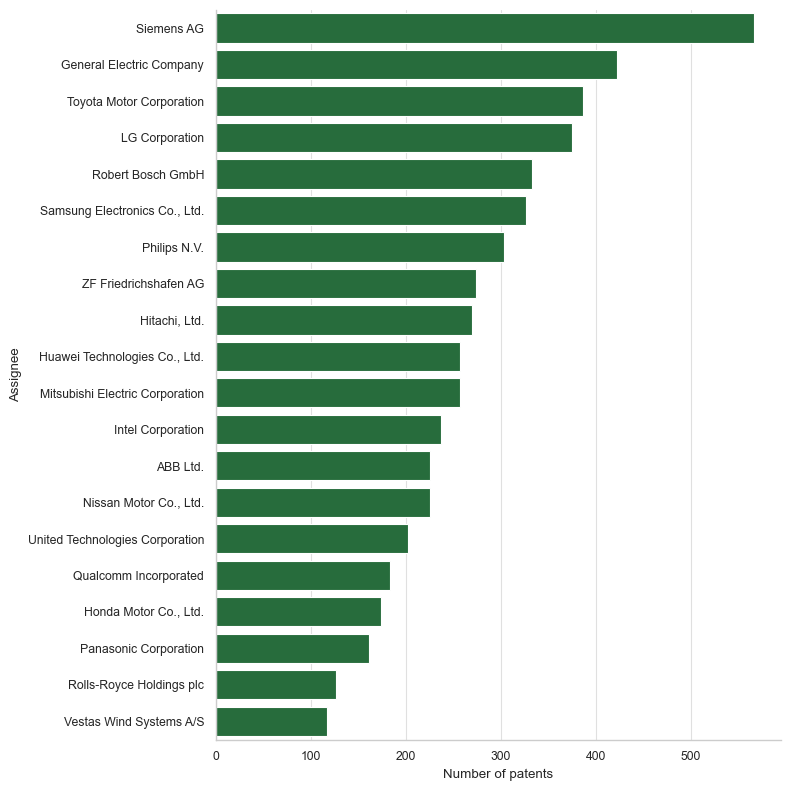

In [16]:
nature_palette = {
    'green': '#1B7837',   # main highlight
    'blue':  '#0072B2',   # secondary (if needed)
    'gray':  '#999999'    # neutral accent
}

plt.rcParams.update({'font.family': 'Helvetica', 'font.size': 9})
sns.set_style("whitegrid", {'grid.linestyle': '-', 'grid.color': '#E0E0E0'})
sns.set_context("paper")

plt.figure(figsize=(8, 8))
ax = sns.barplot(
    x=top_20_assignees.values,
    y=top_20_assignees.index,
    color=nature_palette['green']
)
sns.despine(ax=ax, top=True, right=True)
plt.xlabel('Number of patents')
plt.ylabel('Assignee')
plt.tight_layout()
plt.savefig('fig1a_assignees.pdf', format='pdf', bbox_inches='tight')
plt.show()


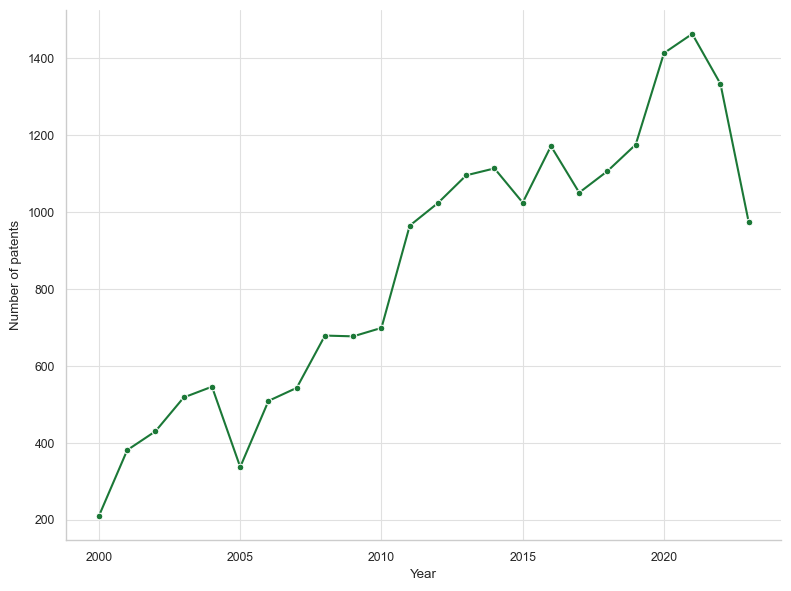

In [17]:
plt.rcParams.update({'font.family': 'Helvetica', 'font.size': 9})
sns.set_style("whitegrid", {'grid.linestyle': '-', 'grid.color': '#E0E0E0'})
sns.set_context("paper")

plt.figure(figsize=(8, 6))
ax = sns.lineplot(
    data=patents_by_year,
    x='publication_date_EPO',
    y='count',
    color=nature_palette['green'],
    marker='o',
    linewidth=1.5
)
sns.despine(ax=ax, top=True, right=True)
plt.xlabel('Year')
plt.ylabel('Number of patents')
plt.tight_layout()
plt.savefig('fig1b_patents_over_time.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [19]:
from iso3166 import countries

# Assuming 'patents_text' is your dataframe

# Create a dictionary to map two-letter country codes to full names
country_dict = {country.alpha2: country.name for country in countries}

# Map the country codes to full names
patents_text['assignee_country_full'] = patents_text['assignee_country'].map(country_dict)

custom_labels = {
    'United States of America': 'USA',
    'United Kingdom of Great Britain and Northern Ireland': 'UK',
    'Korea, Republic of': 'Korea',
    'Taiwan, Province of China': 'Taiwan'
}

# Apply the custom labels
patents_text['assignee_country_full'] = patents_text['assignee_country_full'].replace(custom_labels)

# Count the number of patents by full country name
country_counts = patents_text['assignee_country_full'].value_counts().head(20)


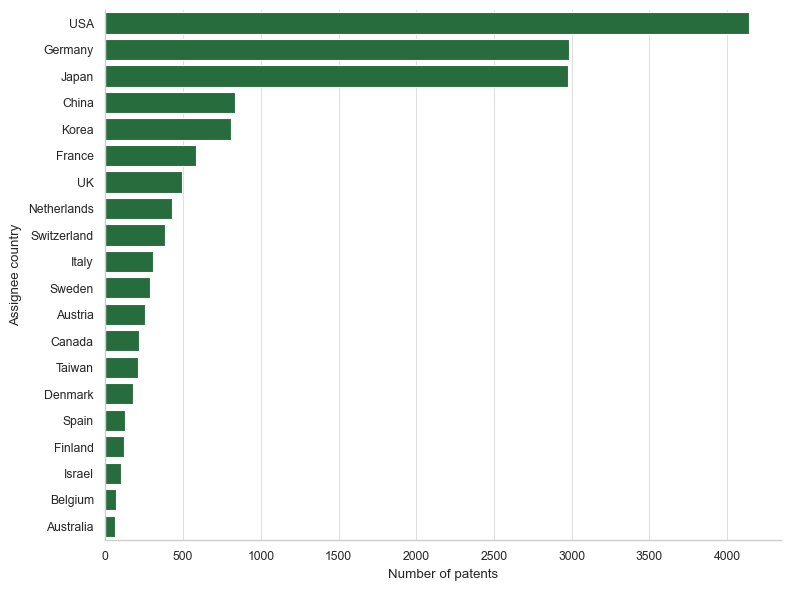

In [20]:
plt.rcParams.update({'font.family': 'Helvetica', 'font.size': 9})
sns.set_style("whitegrid", {'grid.linestyle': '-', 'grid.color': '#E0E0E0'})
sns.set_context("paper")

plt.figure(figsize=(8, 6))
ax = sns.barplot(
    y=country_counts.index,
    x=country_counts.values,
    color=nature_palette['green']
)
sns.despine(ax=ax, top=True, right=True)
plt.xlabel('Number of patents')
plt.ylabel('Assignee country')
plt.tight_layout()
plt.savefig('fig1c_countries.pdf', format='pdf', bbox_inches='tight')
plt.show()
